<a href="https://colab.research.google.com/github/githinjimary/in2deep/blob/development/mg_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THE BARRIER REEF-YOLOV5**

*This notebook is an inspiration from ANDRADA OLTEANU's notebook 🐡GreatBarrierReef: YOLO Full Guide [train+infer]*

#  **> 📚 IMPORT LIBRARIES**

In [ ]:
!pip install -qU wandb
!pip install -qU bbox-utility 

In [ ]:
# Libraries
import os
import sys
import wandb
import torch
import time
import random
import shutil
import yaml
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html



### ⬇ Helper Functions Below

In [ ]:
# ===  W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    
    run = wandb.init(project='g2net', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
     
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

# Step 1. Data Prep


Current Directory /kaggle/working
Notebook Color Scheme:


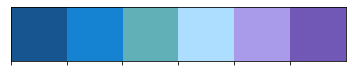

In [ ]:
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Current Directory"+color.E, os.getcwd())
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

In [ ]:
print(color.S+"-Directory Structure-"+color.E)
print(color.S+"Before:"+color.E, os.listdir("../"))

# Create 2 new folders
!mkdir -p '../images'
!mkdir -p '../labels'

print(color.S+"After:"+color.E, os.listdir("../"))

-Directory Structure-
Before: ['src', 'lib', 'input', 'working']
After: ['src', 'images', 'lib', 'input', 'labels', 'working']


In [ ]:
# Import the prepped train dataset
train = pd.read_csv("../input/2021-greatbarrierreef-prep-data/train.csv")
# Remove all images that have no bounding box (removing ~80% of data)
train = train[train["no_annotations"]>0].reset_index(drop=True)

train.sample(3, random_state=24)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,no_annotations,path,f_annotations,path_images,path_labels,width,height,coco_bbox
3825,1,60754,9037,621,1-9037,"[{'x': 424, 'y': 284, 'width': 44, 'height': 33}]",1,../input/tensorflow-great-barrier-reef/train_i...,"[[424, 284, 468, 317]]",/kaggle/images/video_1_9037.jpg,/kaggle/labels/video_1_9037.txt,1280,720,"[[424, 284, 44, 33]]"
2368,1,8503,3925,97,1-3925,"[{'x': 61, 'y': 254, 'width': 67, 'height': 44...",4,../input/tensorflow-great-barrier-reef/train_i...,"[[61, 254, 128, 298], [2, 311, 75, 361], [24, ...",/kaggle/images/video_1_3925.jpg,/kaggle/labels/video_1_3925.txt,1280,720,"[[61, 254, 67, 44], [2, 311, 73, 50], [24, 290..."
178,0,40258,246,246,0-246,"[{'x': 881, 'y': 259, 'width': 28, 'height': 25}]",1,../input/tensorflow-great-barrier-reef/train_i...,"[[881, 259, 909, 284]]",/kaggle/images/video_0_246.jpg,/kaggle/labels/video_0_246.txt,1280,720,"[[881, 259, 28, 25]]"


# Step 2. Copy Images & Labels


## I. The Images

**Copy** from `../input/tensorflow-great-barrier-reef/train_images` to `../images`.


In [ ]:
# Populate the ../images folder

for path in tqdm(train["path"].tolist()):
    split_path = path.split("/")

    # Retrieve the video id (0, 1, 2) and its frame number
    video_id = split_path[-2]
    video_frame = split_path[-1]

    # Create new image path
    path_image = f"../images/{video_id}_{video_frame}"
    
    # Copy file from source (competition data) to destination (our new folder)
    shutil.copy(src=path, dst=path_image)

100%|██████████| 4919/4919 [00:55<00:00, 88.14it/s]


Sample of 3 images from the ../images/ folder: ['video_1_6258.jpg', 'video_2_5396.jpg', 'video_1_5840.jpg']


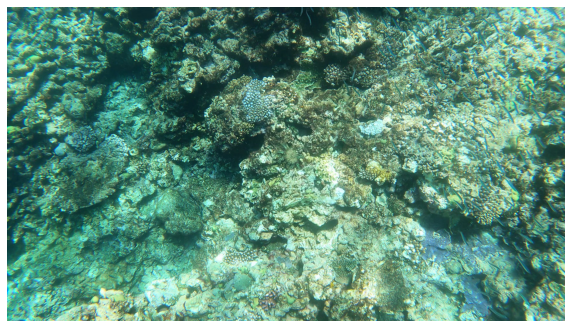

In [ ]:
# Glimpse of images folder now:
print(color.S+"Sample of 3 images from the ../images/ folder:"+color.E, os.listdir("../images")[:3])

plt.figure(figsize=(10, 10))
img_sample = cv2.imread("../images/video_1_6258.jpg")
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
plt.imshow(img_sample)
plt.axis("off");

## II. The Labels

### COCO2YOLO

In [ ]:
def coco2yolo(image_height, image_width, bboxes):
    """
    Converts a coco annotation format [xmin, ymin, w, h] to 
    the corresponding yolo format [xmid, ymid, w, h]
    
    image_height: height of the original image
    image_width: width of the original image
    bboxes: coco boxes to be converted
    return :: 
    
    inspo: https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train
    """
    
    bboxes = np.array(bboxes).astype(float)
    
    # Normalize xmin, w
    bboxes[:, [0, 2]]= bboxes[:, [0, 2]]/ image_width
    # Normalize ymin, h
    bboxes[:, [1, 3]]= bboxes[:, [1, 3]]/ image_height
    
    # Converstion (xmin, ymin) => (xmid, ymid)
    bboxes[:, [0, 1]] = bboxes[:, [0, 1]] + bboxes[:, [2, 3]]/2
    
    # Clip values (between 0 and 1)
    bboxes = np.clip(bboxes, a_min=0, a_max=1)
    
    return bboxes

In [ ]:
# --- Checking---
bbox_example = [[559, 213, 50, 32], [679, 223, 10, 100]]

print(color.E+"From COCO: "+color.E, bbox_example)
print(color.E+"to YOLO:"+color.E, 
      coco2yolo(image_height=720, 
                image_width=1280, 
                bboxes=bbox_example))

From COCO:  [[559, 213, 50, 32], [679, 223, 10, 100]]
to YOLO: [[0.45625    0.31805556 0.0390625  0.04444444]
 [0.534375   0.37916667 0.0078125  0.13888889]]


### Copy Labels



In [ ]:
# Populate the ../labels folder
yolo_bboxes = []

for k in tqdm(range(len(train))):
    
    row_data = train.iloc[k, :]
    height = row_data["height"]
    width = row_data["width"]
    coco_bbox = eval(row_data["coco_bbox"])
    len_bbox = row_data["no_annotations"]
    
    # Create file and write in it
    with open(row_data["path_labels"], 'w') as file:
        
        # In case there is an image with no present annotation
        if len_bbox == 0: 
            file.write("")
            continue
            
        # Convert coco format to yolo format
        yolo_bbox = coco2yolo(height, width, coco_bbox)
        yolo_bboxes.append(yolo_bbox)
        
        # Write annotations in file
        for i in range(len_bbox):
            annot = ["0"] + \
                    yolo_bbox[i].astype(str).tolist() + \
                    ([""] if i+1 == len_bbox else ["\n"])
            
            annot = " ".join(annot).strip()
            file.write(annot)
            

# Add yolo boxes to dataframe
train["yolo_bbox"] = yolo_bboxes

100%|██████████| 4919/4919 [00:02<00:00, 2014.77it/s]


In [ ]:
# Glimpse of labels folder now:
print(color.E+"Sample of 3 labels from the ../labels/ folder:"+color.S, os.listdir("../labels")[:3], "\n")

# Let's read the files
f1 = open('../labels/video_1_4238.txt', 'r')
f2 = open('../labels/video_1_5315.txt', 'r')
f3 = open('../labels/video_0_1006.txt', 'r')

# How the .txt files look?
print(color.E+"File1: "+color.E, f1.read())
print(color.E+"File2: "+color.E, f2.read())
print(color.E+"File3: "+color.E, f3.read())

Sample of 3 labels from the ../labels/ folder: ['video_1_4238.txt', 'video_1_5315.txt', 'video_0_1006.txt'] 

File1:  0 0.27187500000000003 0.5569444444444445 0.034375 0.050 0.430078125 0.6541666666666667 0.03203125 0.07222222222222222
File2:  0 0.340234375 0.25069444444444444 0.02421875 0.051388888888888890 0.26640625 0.3819444444444444 0.025 0.041666666666666664
File3:  0 0.7941406249999999 0.5326388888888889 0.07109375 0.08472222222222223


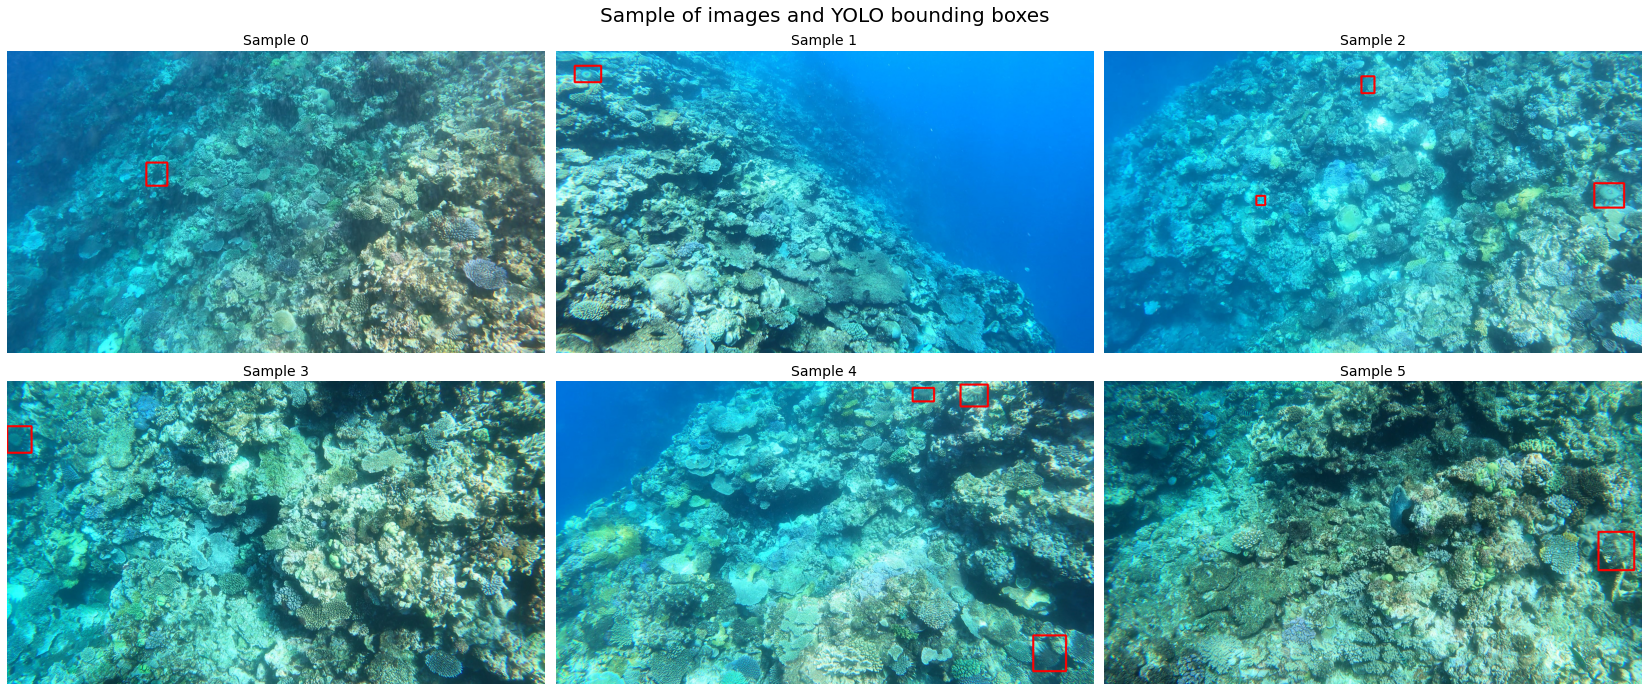

In [ ]:
# Retrieve a sample of data
images = os.listdir("/kaggle/images")[6:12]
vid_id = [im.split("_")[1] for im in images]
seq_id = [im.split("_")[2].split(".")[0] for im in images]

# Plot
fig, axs = plt.subplots(2, 3, figsize=(23, 10))
axs = axs.flatten()
fig.suptitle(f"Sample of images and YOLO bounding boxes", fontsize = 20)

for k in range(6):
    
    # Get the data
    im = cv2.imread(f"/kaggle/images/{images[k]}")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dh, dw, _ = im.shape
    txt = open(f"/kaggle/labels/video_{vid_id[k]}_{seq_id[k]}.txt", "r").read().split(" ")[1:]
    no_boxes = int(len(txt)/4)
    
    # Draw boxes
    i = 0
    while i < no_boxes:
        i = i+4
        box = txt[:i][-4:]
        
        # Src: https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # from YOLO to COCO
        x, y, w, h = box
        x, y, w, h = float(x), float(y), float(w), float(h)

        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0: l = 0
        if r > dw - 1: r = dw - 1
        if t < 0: t = 0
        if b > dh - 1: b = dh - 1

        cv2.rectangle(im, (l, t), (r, b), (255,0,0), 3)
        
    # Show image with bboxes
    axs[k].set_title(f"Sample {k}", fontsize = 14)
    axs[k].imshow(im)
    axs[k].set_axis_off()

plt.tight_layout()
plt.show()

# Step 3. YOLO Configuration

## I. Splitting the Data


In [ ]:
# Using Video 0 and 2 for training and 1 for validation
train_data = train[train["video_id"].isin([0, 2])]
test_data = train[train["video_id"].isin([1])]

# Get path to images & labels
train_images = list(train_data["path_images"])
train_labels = list(train_data["path_labels"])

test_images = list(test_data["path_images"])
test_labels = list(test_data["path_labels"])

print(color.S+"Train Length:"+color.E, len(train_data), "\n" +
      color.S+"Test Length:"+color.E, len(test_data))

Train Length: 2820 
Test Length: 2099


## II. Configuration Setup


In [ ]:
print(color.E+"../working BEFORE:"+color.S, os.listdir("../working"))

# Create train and test path data
with open("../working/train_images.txt", "w") as file:
    for path in train_images:
        file.write(path + "\n")
        
with open("../working/test_images.txt", "w") as file:
    for path in test_images:
        file.write(path + "\n")


# Create configuration
config = {'path': '/kaggle/working',
          'train': '/kaggle/working/train_images.txt',
          'val': '/kaggle/working/test_images.txt',
          'nc': 1,
          'names': ['cots']}

with open("../working/cots.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

        
print(color.E+"../working AFTER:"+color.S, os.listdir("../working"))

../working BEFORE: ['__notebook__.ipynb']
../working AFTER: ['test_images.txt', '__notebook__.ipynb', 'cots.yaml', 'train_images.txt']


In [ ]:
%cd /kaggle/working
!rm -r /kaggle/working/yolov5
# !git clone https://github.com/ultralytics/yolov5 # clone
!cp -r /kaggle/input/yolov5-lib-ds /kaggle/working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # check

YOLOv5 🚀 2022-2-8 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3163.4/4030.7 GB disk)


## III. Training

In [ ]:
# --- PARAMETERS ---

SIZE = 1280
BATCH_SIZE = 16
EPOCHS = 1
MODEL = "yolov5s"
WORKERS = 1
PROJECT = "GreatBarrierReef"
RUN_NAME = f"{MODEL}_size{SIZE}_epochs{EPOCHS}_batch{BATCH_SIZE}_simple"
# ------------------

In [ ]:
## Training - train.py can be found in yolov5 directory
!python train.py --img {SIZE}\
                --batch {BATCH_SIZE}\
                --epochs {EPOCHS}\
                --data /kaggle/working/cots.yaml\
                --weights {MODEL}.pt\
                --workers {WORKERS}\
                --project {PROJECT}\
                --name {RUN_NAME}\
                --exist-ok

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
Weights & Biases: run 'pip install wandb' to automatically track and visualize YOLOv5 🚀 runs (RECOMMENDED)
100%|██████████████████████████████████████| 14.0M/14.0M [00:00<00:00, 98.4MB/s]

train: Scanning '/kaggle/working/train_images' images and labels...2820 found, 0
val: Scanning '/kaggle/working/test_images' images and labels...2099 found, 0 mi
       0/0     13.2G   0.09279   0.02389         0         5      1280: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
               Class     Images     Labels          P          R     mAP@.5 mAP@
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f340f30f950>
Traceback (most r

## IV. Inspecting the results

All training results are saved to `../working/yolov5/runs/train/` with incrementing run directories (first run is `exp`, then `exp2`, `exp3` and so on).


In [ ]:
# Run details
os.listdir(f"{PROJECT}/{RUN_NAME}")

['val_batch0_labels.jpg',
 'val_batch2_pred.jpg',
 'labels.jpg',
 'val_batch2_labels.jpg',
 'train_batch1.jpg',
 'results.png',
 'hyp.yaml',
 'val_batch1_pred.jpg',
 'val_batch0_pred.jpg',
 'results.csv',
 'PR_curve.png',
 'F1_curve.png',
 'train_batch2.jpg',
 'P_curve.png',
 'R_curve.png',
 'train_batch0.jpg',
 'val_batch1_labels.jpg',
 'opt.yaml',
 'labels_correlogram.jpg',
 'weights',
 'events.out.tfevents.1644340024.6a6a9d3c6242.155.0',
 'confusion_matrix.png']

In [ ]:
# Remove training data files
!rm -r '/kaggle/images'
!rm -r '/kaggle/labels'

In [ ]:
# Change our position within the directory back
%cd /kaggle/working

/kaggle/working


In [ ]:
# --- Trained Model ---
MODEL_PATH = "../input/reef-baseline-fold12/l6_3600_uflip_vm5_f12_up/f1/best.pt"

# Load the model
model = torch.hub.load("../input/yolov5-lib-ds", "custom",
                       path=MODEL_PATH,
                       source='local', force_reload=True)

# BoundingBox Confidence
model.conf = 0.01
# Intersection Over Union
model.iou = 0.5

YOLOv5 🚀 2022-2-8 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


In [ ]:
# Create Ultralytics directory
!mkdir -p /root/.config/Ultralytics
# Copy folder to root
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

## III. Prediction

In [ ]:
import greatbarrierreef

# Initialize the environment
env = greatbarrierreef.make_env()
# Iterator that loops through the submission dataset
# !!! you can run this cell only once
iter_test = env.iter_test()

🐠 Looking at the requirements, the sample prediction must look as follows: `sample_prediction_df['annotations'] = '0.5 0 0 100 100'`. Hence, the submitted bounding box should have the format `'conf x y width height'`.

If there are multiple boxes in one image they would look like: `'conf1 x1 y1 width1 height1 conf2 x2 y2 width2 height2'`.

In [ ]:
# !!! you can run this cell only once

# Loop through the test file
for k, (image, sample_prediction_df) in enumerate(tqdm(iter_test)):
    
    annotation = ""
    prediction = model(image, size=3600, augment=True)
    print(color.S+"Prediction Object:"+color.E, prediction.pandas())
    print(color.S+"Bounding Boxes:"+color.E, prediction.pandas().xyxy[0])
    print(color.S+"Shape:"+color.E, prediction.pandas().xyxy[0].shape[0])
    
    if prediction.pandas().xyxy[0].shape[0] == 0:
        annotation = ""
    else:
        for k, row in prediction.pandas().xyxy[0].iterrows():
            if row.confidence > 0.15:
                conf = row.confidence
                x = int(row.xmin)
                y = int(row.ymin)
                width = int(row.xmax-row.xmin)
                height = int(row.ymax-row.ymin)
                annotation += "{} {} {} {} {}".format(conf, x, y, width, height)
    
    sample_prediction_df['annotations'] = annotation.strip(' ')
    
    # Register your predictions
    env.predict(sample_prediction_df)

0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


1it [00:00,  1.65it/s]

Prediction Object: <models.common.Detections object at 0x7ff708076a90>
Bounding Boxes:          xmin        ymin        xmax        ymax  confidence  class  name
0  518.872009  231.392441  545.905945  253.103256    0.017001      0  reef
1    0.971384  196.635666   77.123459  239.733734    0.010127      0  reef
Shape: 2


2it [00:00,  2.58it/s]

Prediction Object: <models.common.Detections object at 0x7ff6ec26e5d0>
Bounding Boxes:          xmin        ymin        xmax        ymax  confidence  class  name
0  600.557861  243.030930  623.780151  261.813477    0.045331      0  reef
1  480.432037  241.023102  507.622101  258.203674    0.015229      0  reef
2  724.935242  178.151230  767.083984  200.274521    0.014969      0  reef
Shape: 3


3it [00:01,  2.71it/s]

Prediction Object: <models.common.Detections object at 0x7ff6e77d3050>
Bounding Boxes:          xmin        ymin        xmax        ymax  confidence  class  name
0  333.503693  299.734955  364.789612  321.550842    0.089441      0  reef
1    1.193656  198.527130   64.327766  241.472519    0.053088      0  reef
2   14.444919    1.359814   68.918930   21.589460    0.019370      0  reef
Shape: 3
